- Daisy:
`skimage.feature.daisy(image, step=4, radius=15, rings=3, histograms=8, orientations=8, normalization='l1', sigmas=None, ring_radii=None, visualize=False)` \\
Daisy recorre la imagen de a "step" pixeles considerando cada paso un punto clave, en el cual considera un anillo el cual rodea de otros anillos. Lo rodea con "rings" anillos de radio "radius".


# Config

A fines de elaboración, configuramos qué queremos que se recalcule y qué queremos usar desde Drive.

In [1]:
recalcular_descriptores = False
guardar_descriptores = False
recalculcar_pipeline = True

# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.io import imread
from skimage.feature import SIFT
from skimage.feature import daisy
from skimage.transform import resize

from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from scipy.spatial.distance import cdist
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import time
import glob
import os
# from tqdm.notebook import tqdm
from tqdm import tqdm
import warnings
import math
import random

import pickle

warnings.filterwarnings('ignore')

# Configuración para gráficos
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


### ***UTIL***

In [3]:
def indicesDeCategoriaEnLista(etiquetas, categoria):
  """Devuelve los indices donde la etiqueta sea igual que la categoria"""
  return [j for j, etiq in enumerate(etiquetas) if etiq == categoria]

def indexadoIndirecto(idx, lista_indices, lista_principal):
  """Devuelve el resultado de indexar indirectamente una lista"""
  return lista_principal[lista_indices[idx]]

### ***1. Carga y Exploración del Dataset***

**Uso del Drive**

Al tratarse de un dataset con tantos elementos, recomendamos utilizar el dataset directamente desde drive en vez de cargarlo cada vez que quieran trabajar con el. Intenten que todos los participantes del grupo lo tengan en el misma direccion para hacer mas fluido su trabajo.

Data set: [Rock Paper Scissors](https://www.kaggle.com/datasets/drgfreeman/rockpaperscissors?select=scissors)

Para los archivos .pkl: ....

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
def pathDeArchivoPorCategoria(data_path, categoria):
  """
  Devuelve la direccion de todos las imagenes en la carpeta de la categoria

  Returns:
    archivos: una lista con cada una de las direcciones de archivos.
  """

  categoria_path = os.path.join(data_path, categoria)

  archivos = glob.glob(os.path.join(categoria_path, "*.jpg")) + \
             glob.glob(os.path.join(categoria_path, "*.jpeg")) + \
             glob.glob(os.path.join(categoria_path, "*.png"))

  return archivos

def cargarImagenPorArchivo(archivo):
  """
  Devuelve la imagen cargada en blanco y negro, habiendo sido reescalada si fuera necesario.

  Returns:
    img: La imgen cargada por Archivo.
  """

  img = imread(archivo, as_gray=True)

  # Redimensionar si es necesario (opcional)
  if img.shape[0] > 400 or img.shape[1] > 400:
    img = resize(img, (300, 300), anti_aliasing=True)

  return img

In [6]:
def cargarDataSet(data_path, categorias):
  """
  Carga todas las imágenes del dataset organizadas por categoría

  Returns:
    imagenes: lista de imágenes en escala de grises
    etiquetas: lista de etiquetas correspondientes
    nombres_archivo: lista con nombres de archivos para referencia
  """

  imagenes = []
  etiquetas = []
  nombres_archivo = []

  print(f"Cargando dataset desde: {data_path}")

  # Cargamos las imagenes de cada Categoria
  for categoria in categorias:

    archivos = pathDeArchivoPorCategoria(data_path, categoria)
    archivos = archivos

    print(f"  {categoria}: {len(archivos)} imágenes")

    for archivo in tqdm(archivos, desc=f"Cargando {categoria}"):

      try:
        img = cargarImagenPorArchivo(archivo)
        imagenes.append(img)
        etiquetas.append(categoria)
        nombres_archivo.append(os.path.basename(archivo))

      except Exception as e:
        print(f"Error cargando {archivo}: {e}")

  return imagenes, etiquetas, nombres_archivo


***CARGA***

### ADAPTAR CATEGORIAS, COLORES y PATH

In [7]:
# Definir categorías de especies
CATEGORIAS = ['paper', 'rock', 'scissors']
COLORES_CATEGORIAS = ['#9e0142', '#d53e4f', '#f46d43']

# Paths del dataset
DATA_PATH = "dataset/"
TRAIN_PATH = os.path.join(DATA_PATH, "train")
TEST_PATH = os.path.join(DATA_PATH, "test")

# Cargar datasets de entrenamiento y prueba
print("=" * 50)
print("CARGANDO DATASET DE ENTRENAMIENTO")
print("=" * 50)
imagenes_train, etiquetas_train, nombres_train = cargarDataSet(TRAIN_PATH, CATEGORIAS)

print("\n" + "=" * 50)
print("CARGANDO DATASET DE PRUEBA")
print("=" * 50)
imagenes_test, etiquetas_test, nombres_test = cargarDataSet(TEST_PATH, CATEGORIAS)

print(f"\n📊 RESUMEN DEL DATASET:")
print(f"Training: {len(imagenes_train)} imágenes")
print(f"Testing: {len(imagenes_test)} imágenes")
print(f"Total: {len(imagenes_train) + len(imagenes_test)} imágenes")

CARGANDO DATASET DE ENTRENAMIENTO
Cargando dataset desde: dataset/train
  paper: 662 imágenes


Cargando paper: 100%|██████████| 662/662 [00:01<00:00, 426.97it/s]


  rock: 676 imágenes


Cargando rock: 100%|██████████| 676/676 [00:01<00:00, 416.06it/s]


  scissors: 700 imágenes


Cargando scissors: 100%|██████████| 700/700 [00:01<00:00, 430.05it/s]



CARGANDO DATASET DE PRUEBA
Cargando dataset desde: dataset/test
  paper: 50 imágenes


Cargando paper: 100%|██████████| 50/50 [00:00<00:00, 388.94it/s]


  rock: 50 imágenes


Cargando rock: 100%|██████████| 50/50 [00:00<00:00, 420.46it/s]


  scissors: 50 imágenes


Cargando scissors: 100%|██████████| 50/50 [00:00<00:00, 436.91it/s]


📊 RESUMEN DEL DATASET:
Training: 2038 imágenes
Testing: 150 imágenes
Total: 2188 imágenes


***VISUALIZACION***

In [8]:
# Visualización de ejemplos del dataset
def mostrarEjemplosDataSet(imagenes, etiquetas, categorias, n_ejemplos=2):
  """Muestra ejemplos de cada categoría del dataset"""

  fig, axes = plt.subplots(len(categorias), n_ejemplos, figsize=(15, 12))
  fig.suptitle('Ejemplos del Dataset por Categoría', fontsize=16, fontweight='bold')

  for i, categoria in enumerate(categorias):
    # Encontrar índices de esta categoría
    indices_categoria = indicesDeCategoriaEnLista(etiquetas, categoria)
    random.shuffle(indices_categoria)

    # Mostramos imagenes de Ejemplos por categoria
    for j in range(n_ejemplos):

        img = indexadoIndirecto(j, indices_categoria, imagenes)
        axes[i, j].imshow(img, cmap='gray', clim=(0,1))
        axes[i, j].set_title(f'{categoria}', fontweight='bold')
        axes[i, j].axis('off')

  plt.tight_layout()
  plt.show()

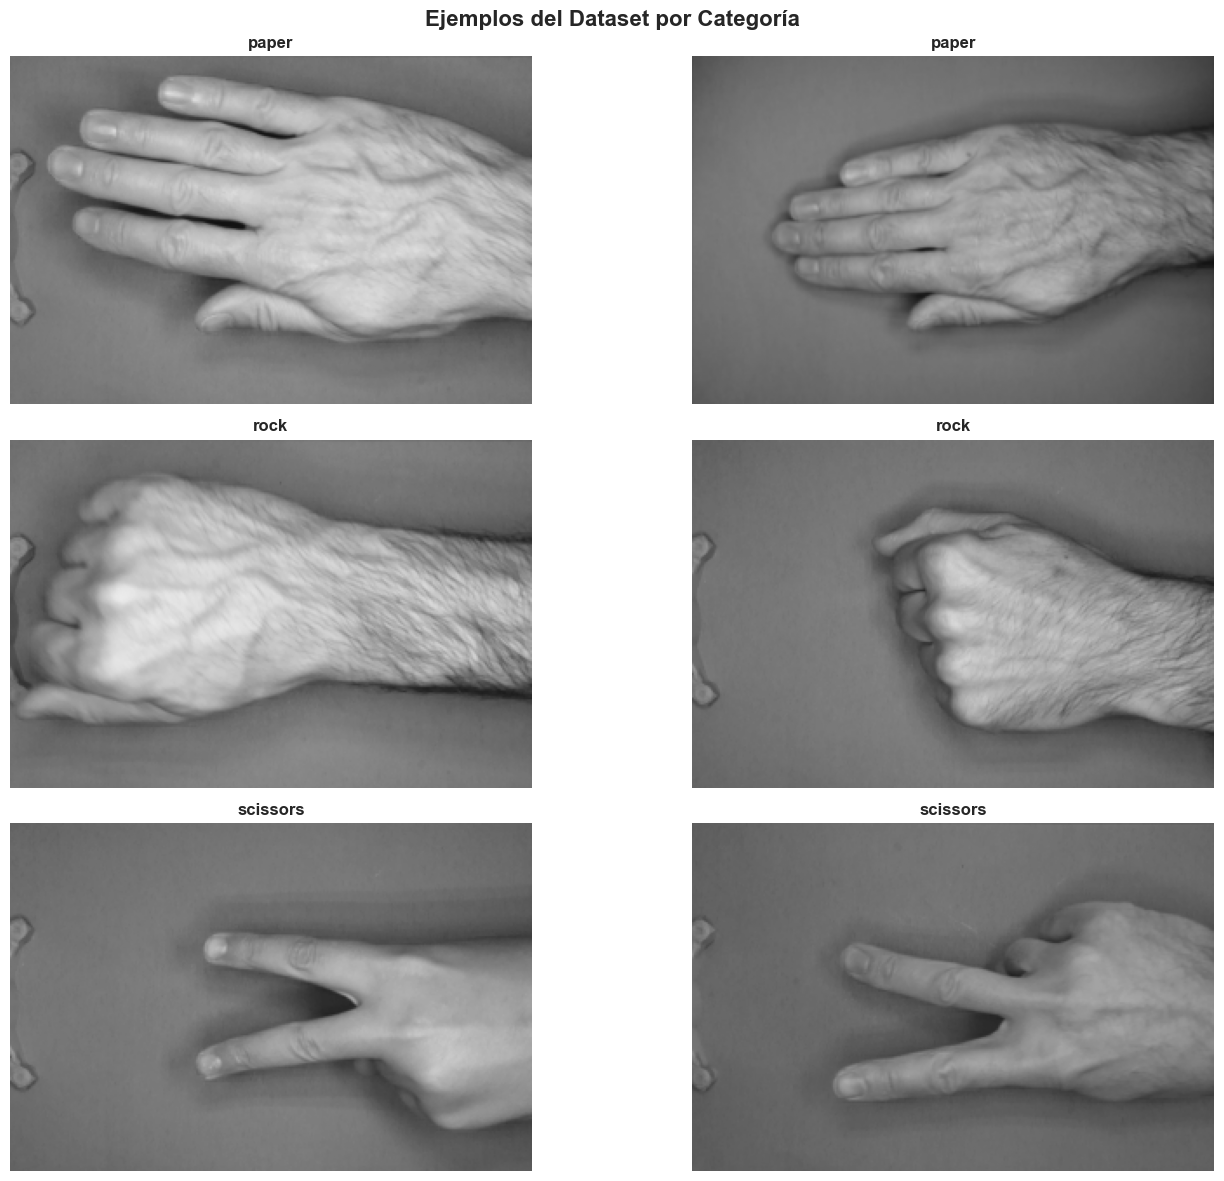

In [9]:
mostrarEjemplosDataSet(imagenes_test, etiquetas_test, CATEGORIAS)

### ***2. Extracción de Características Daisy***
Con las imagenes cargadas, empezaremos por extraer cada uno de sus keypoints y descriptores de Daisy correspondientes. Luego utilizaremos estos datos para crear nuestras palabras visuales.

### MENCIONAR TAMAÑO DE LOS DESCRIPTORES

In [10]:
def extraerDaisyDataSet(imagenes, step = 16, image_index=0, **kwargs):
    keypoints = []
    descriptores = []
    stats = {cat: {'total_keypoints': 0, 'promedio_keypoints': 0} for cat in CATEGORIAS}

    for i, img in enumerate(imagenes):
      if i == image_index:
        desc, image_daisy = daisy(img, step=step, visualize=True, **kwargs)
        plt.imsave('daisy_visualization_example.png', image_daisy, cmap='gray')
      else:
        desc = daisy(img, step = step , **kwargs)

      desc_flat = desc.reshape(-1, desc.shape[-1]).astype(np.float32)
      descriptores.append(desc_flat)
      
      # Guardar los keypoints (coordenadas de la grilla)
      radius = kwargs.get('radius')
      x, y = np.meshgrid(
            np.arange(radius, img.shape[1] - radius +1, step), 
            np.arange(radius, img.shape[0] - radius +1, step)
      )
      puntos = np.vstack([x.ravel(), y.ravel()]).T
      keypoints.append(puntos)

      # Estadísticas
      stats[CATEGORIAS[i % len(CATEGORIAS)]]['total_keypoints'] += len(desc_flat)
    # # Calcular promedios
    # for cat in CATEGORIAS:
    #     stats[cat]['promedio_keypoints'] = stats[cat]['total_keypoints'] / max(1, sum([1 for e in imagenes if cat in str(e)]))
    return keypoints, descriptores, stats

In [11]:
if recalcular_descriptores:

  # Extraer Daisy del dataset de entrenamiento
  print("\n" + "=" * 50)
  print("EXTRACCIÓN DE CARACTERÍSTICAS Daisy - TRAINING")
  print("=" * 50)

  keypoints_train, descriptores_train, stats_train = extraerDaisyDataSet(imagenes_train, step=45, image_index = 5, radius=30, rings=2, histograms=6, orientations=8)

  if guardar_descriptores:
    # Guardamos así no lo calculamos todo el tiempo
    ruta = 'daisy_train.pkl'
    with open(ruta, 'wb') as f:
      pickle.dump((keypoints_train, descriptores_train, stats_train), f)

  # Mostrar estadísticas
  print("\n📊 ESTADÍSTICAS DE EXTRACCIÓN Daisy:")
  for categoria in CATEGORIAS:
    total = stats_train[categoria]['total_keypoints']
    cantidad = etiquetas_train.count(categoria)
    stats_train[categoria]['promedio_keypoints'] = total / max(1, cantidad)
    promedio = stats_train[categoria]['promedio_keypoints']
    print(f"{categoria}: {total} keypoints total, {promedio:.1f} promedio por imagen")

In [12]:
if not recalcular_descriptores:

  # Cargar los resultados

  ruta = 'daisy_train.pkl'

  with open(ruta, 'rb') as f:
    keypoints_train, descriptores_train, stats_train = pickle.load(f)

***VISUALIZACION***


VISUALIZACIÓN DE KEYPOINTS


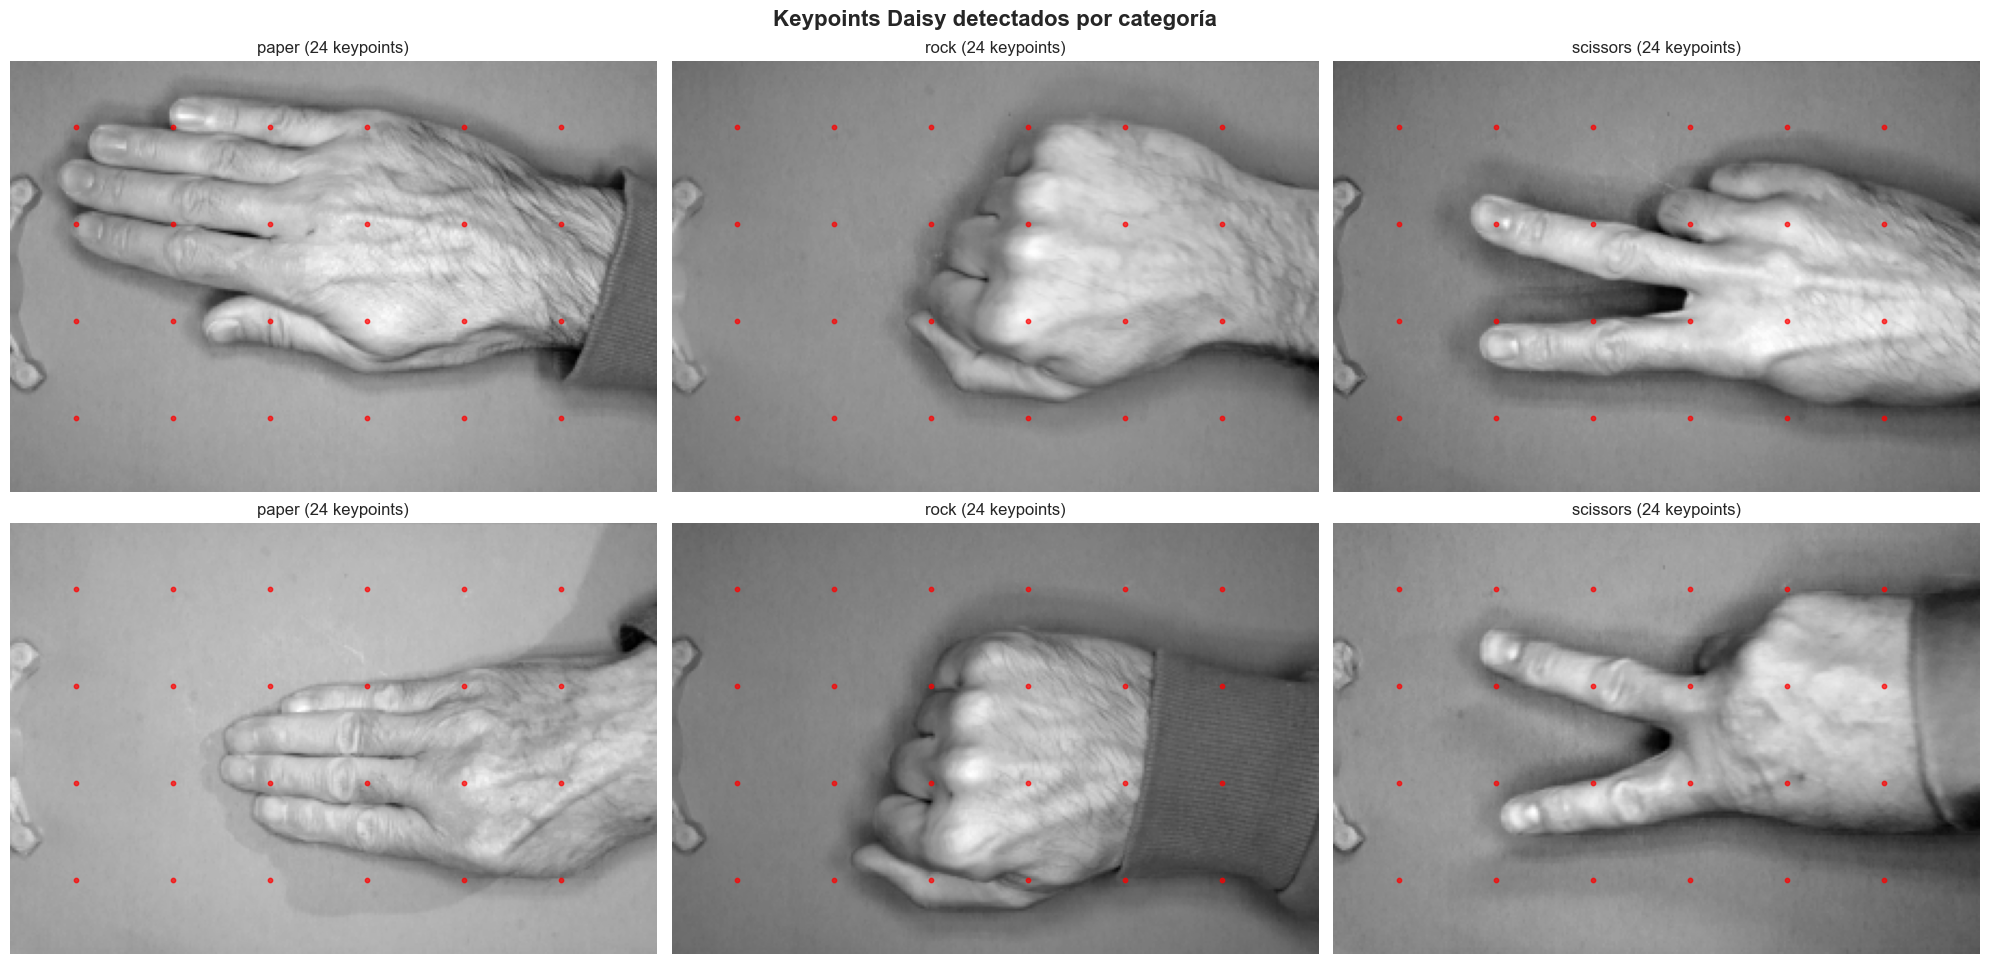

In [13]:
# Visualizar keypoints en ejemplos
def mostrar_keypoints_ejemplos(imagenes, keypoints, etiquetas, categorias):
  """Muestra keypoints detectados en ejemplos de cada categoría"""

  fig, axes = plt.subplots(2, len(categorias), figsize=(20, 10))
  fig.suptitle('Keypoints Daisy detectados por categoría', fontsize=16, fontweight='bold')

  for i, categoria in enumerate(categorias):
    indices_categoria = indicesDeCategoriaEnLista(etiquetas, categoria)
    random.shuffle(indices_categoria)

    for row in range(2):
      img = indexadoIndirecto(row, indices_categoria, imagenes)
      kp = indexadoIndirecto(row, indices_categoria, keypoints)

      # Imagen original
      axes[row, i].imshow(img, cmap='gray')

      # Keypoints
      axes[row, i].scatter(kp[:, 0], kp[:, 1], s=10, c='red', alpha=0.7)

      axes[row, i].set_title(f'{categoria} ({len(kp)} keypoints)')
      axes[row, i].axis('off')

  plt.tight_layout()
  plt.show()

print("\n" + "=" * 50)
print("VISUALIZACIÓN DE KEYPOINTS")
print("=" * 50)
mostrar_keypoints_ejemplos(imagenes_train, keypoints_train, etiquetas_train, CATEGORIAS)

### ***3. Cross Validation***

Para poder encontrar los mejores parametros a usar en el categorizador sin caer en la trampa de **sobreajustarse a los datos de test**, utilizaremos la tecnica de **Cross Validation**.

Dividiremos nuestro set de entrenamiento en 5 subsets balanceados en categoria y aleatorios. Por cada uno de los subsets, tomaremos el resto de los 4 para **entrenar un categorizador** utilizando los meta-parametros a testear (numero de clusters, batch size, etc) y los testearemos sobre el subset apartado.

Por ultimo, utilizaremos la combinacion de meta-parametros que mejor accuracy hayan conseguido en **promedio**.

Con esta tecnica aumentamos las chances de generalizar sin tener que aumentar los datos de entrenamiento, ya que estariamos eligiendo los parametros que mayor capacidad de generalizacion obtuvieron.

In [14]:
def getPorcionDeSubset(lista, indices_cat, cat_subset_inicio, cat_subset_fin):
  """
    Devuelve una sublista del arreglo original siendo indexada indirectamente
    por un arreglo con los indices de una categoria en especifico
  """

  return [indexadoIndirecto(idx, indices_cat, lista) for idx in range(cat_subset_inicio, cat_subset_fin)]

def crearSubsets(imagenes, etiquetas, nombres, keypoints, descriptores, n_subsets=5):
  """Devuelve una lista con los subsets creados al dividir el dataset de entrenamiento original"""

  # Encontramos los indices que le pertenecen a cada categoria (3
  # Encontramos cuantos item de cada categoria deberia haber por subset
  indices_categorias = {cat: indicesDeCategoriaEnLista(etiquetas,cat) for cat in CATEGORIAS}
  categoria_por_subset = {cat: math.ceil(len(indices_categorias[cat]) / n_subsets) for cat in CATEGORIAS}

  # Reordenamos los indices de las categorias de forma aleatoria
  for cat in CATEGORIAS:
    random.shuffle(indices_categorias[cat])

  subsets = []

  for subset_index in range(n_subsets):
    subset = {
        'imagenes': [],
        'etiquetas': [],
        'nombres': [],
        'keypoints': [],
        'descriptores': [],
        'stats': {cat: {'num_images': 0} for cat in CATEGORIAS}
      }

    for cat in CATEGORIAS:

      cat_indices = indices_categorias[cat]
      cat_subset_inicio = subset_index * categoria_por_subset[cat]
      cat_subset_fin = min(cat_subset_inicio + categoria_por_subset[cat], len(indices_categorias[cat]))

      cat_etiquetas = getPorcionDeSubset(etiquetas, cat_indices, cat_subset_inicio, cat_subset_fin)
      cat_descriptores = getPorcionDeSubset(descriptores, cat_indices, cat_subset_inicio, cat_subset_fin)
      cat_nombres = getPorcionDeSubset(nombres, cat_indices, cat_subset_inicio, cat_subset_fin)
      cat_imagenes = getPorcionDeSubset(imagenes, cat_indices, cat_subset_inicio, cat_subset_fin)
      cat_keypoints = getPorcionDeSubset(keypoints, cat_indices, cat_subset_inicio, cat_subset_fin)

      subset['etiquetas'] += (cat_etiquetas)
      subset['nombres'] += (cat_nombres)
      subset['descriptores']+=(cat_descriptores)
      subset['imagenes']+=(cat_imagenes)
      subset['keypoints']+=(cat_keypoints)

      subset['stats'][cat]['num_images'] = len(cat_imagenes)

    subsets.append(subset)

  return subsets

In [15]:
subsets = crearSubsets(imagenes_train, etiquetas_train, nombres_train, keypoints_train, descriptores_train)

for i in range(len(subsets)):
    subset = subsets[i]

    print(f"Subset {i}")
    print(f"Imagenes Totales: {len(subset['etiquetas'])}")

    for categoria in CATEGORIAS:
      print(f"\t{categoria}: {subset['stats'][categoria]['num_images']} imagenes")

    print("\n")

Subset 0
Imagenes Totales: 409
	paper: 133 imagenes
	rock: 136 imagenes
	scissors: 140 imagenes


Subset 1
Imagenes Totales: 409
	paper: 133 imagenes
	rock: 136 imagenes
	scissors: 140 imagenes


Subset 2
Imagenes Totales: 409
	paper: 133 imagenes
	rock: 136 imagenes
	scissors: 140 imagenes


Subset 3
Imagenes Totales: 409
	paper: 133 imagenes
	rock: 136 imagenes
	scissors: 140 imagenes


Subset 4
Imagenes Totales: 402
	paper: 130 imagenes
	rock: 132 imagenes
	scissors: 140 imagenes




In [16]:
def imagenesDeEjemploSubSet(subset, n_ejemplos=4):
  """Muestra ejemplos de cada categoría del subset"""

  fig, axes = plt.subplots(len(CATEGORIAS), n_ejemplos, figsize=(15, 12))
  fig.suptitle('Ejemplos del Sub Dataset por Categoría', fontsize=16, fontweight='bold')

  for i, categoria in enumerate(CATEGORIAS):
    # Encontrar índices de esta categoría
    indices_categoria = indicesDeCategoriaEnLista(subset['etiquetas'], categoria)
    random.shuffle(indices_categoria)

    # Mostramos imagenes de Ejemplos por categoria
    for j in range(n_ejemplos):

        img = indexadoIndirecto(j, indices_categoria, subset['imagenes'])
        axes[i, j].imshow(img, cmap='gray', clim=(0,1))
        axes[i, j].set_title(f'{categoria}', fontweight='bold')
        axes[i, j].axis('off')

  plt.tight_layout()
  plt.show()

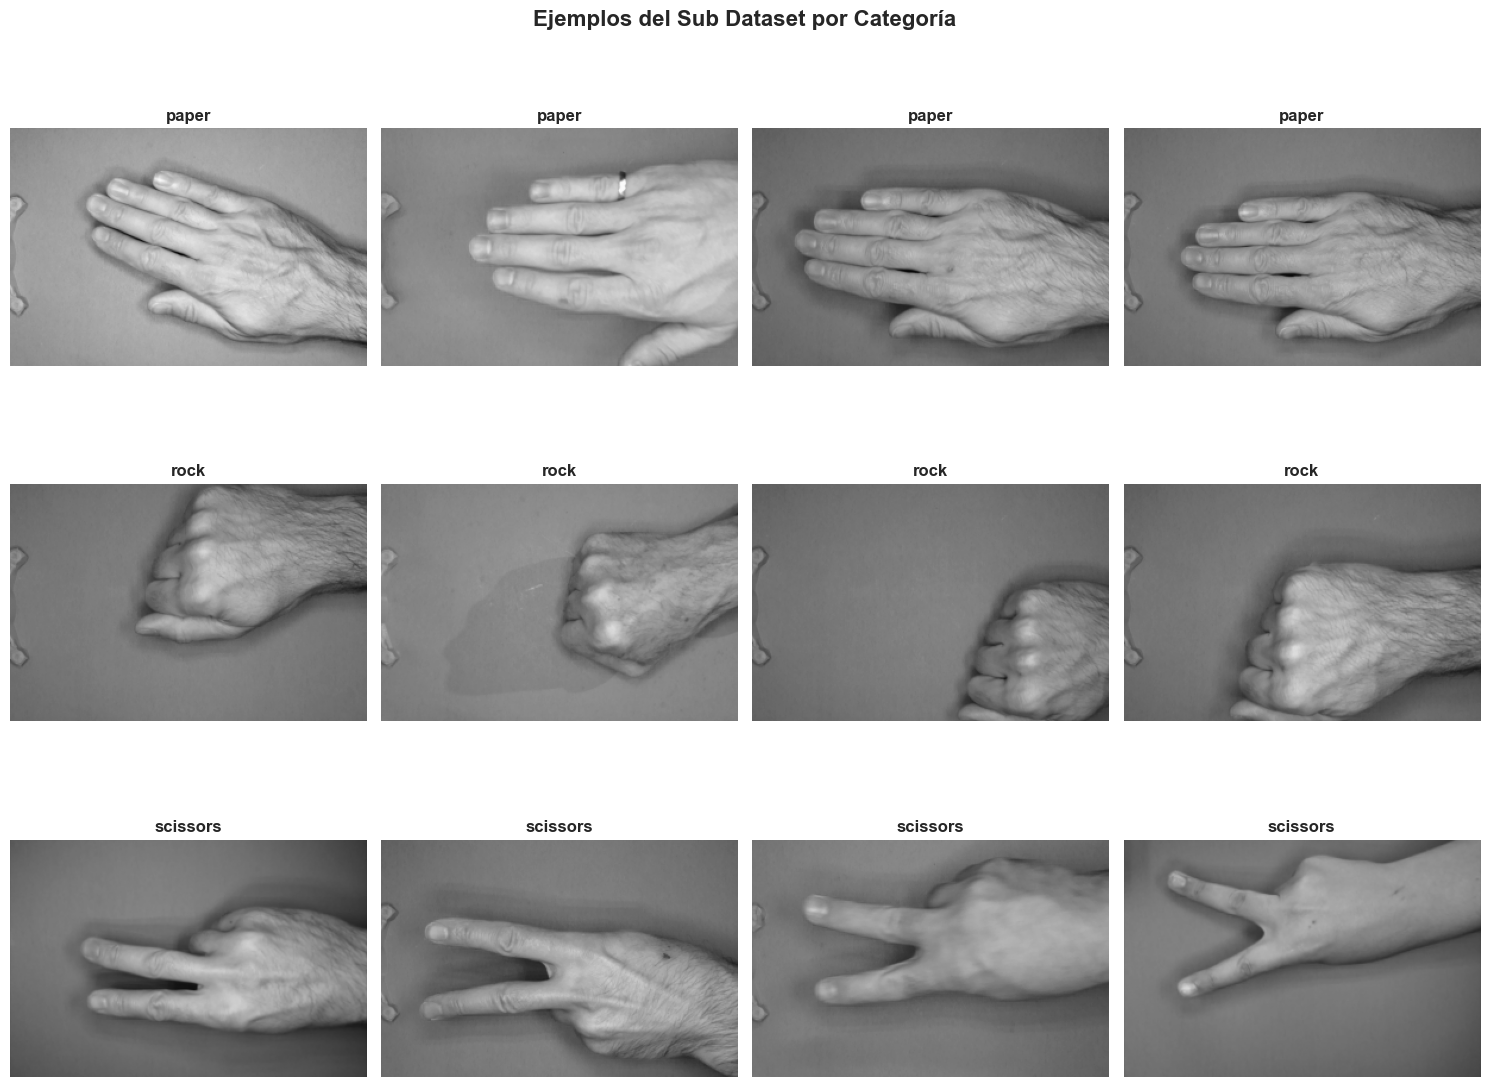

In [17]:
imagenesDeEjemploSubSet(subsets[0])

In [18]:
def unirSubsets(subsets):
  """Devuelve un subset conformado por la union de los subset en la lista"""

  subset_union = {
        'imagenes': [],
        'etiquetas': [],
        'nombres': [],
        'keypoints': [],
        'descriptores': [],
        'stats': {cat: {'num_images': 0} for cat in CATEGORIAS}
      }

  for subset in subsets:

    subset_union['etiquetas'] += subset['etiquetas']
    subset_union['nombres']+= subset['nombres']
    subset_union['descriptores']+= subset['descriptores']
    subset_union['imagenes']+= subset['imagenes']
    subset_union['keypoints']+= subset['keypoints']

    for cat in CATEGORIAS:
      subset_union['stats'][cat]['num_images'] += len(subset['etiquetas'])

  return subset_union


### ***4. Creación del Vocabulario Visual***

Ya teniendo los descriptores, podemos clasificarlos para comprender que keypoints eran similares a traves de las imagenes y empezar a hablar sobre el contenido de ellas.


---

***Construccion de Vocabulario Visual*** ➡️ *Representacion BOW* ➡️ *Procesamiento de la Representacion* ➡️ *Entrenamiento de Categorizador* ➡️ *Validacion*

In [19]:
# Crear matriz global de descriptores para clustering
def crearMatrizDescriptores(descriptores_dataset):
    """
    Combina todos los descriptores en una matriz global para poder realizar clustering
    Donde cada fila es un descriptor
    """
    matriz_descriptores = []

    for descriptores_imagen in descriptores_dataset:
      matriz_descriptores.append(descriptores_imagen)

    matriz_descriptores = np.vstack(matriz_descriptores)

    return matriz_descriptores

In [20]:
def construirVocabulario(descriptores, n_clusters=100, metric='euclidean', linkage='ward'):
    """
    Construye vocabulario visual usando Agglomerative Clustering.

    Returns:
        modelo: objeto con labels y centroides de los clusters
    """

    print(f"Construyendo vocabulario con Agglomerative Clustering (n_clusters={n_clusters})...")
    modelo = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
    labels = modelo.fit_predict(descriptores)

    centroides = np.zeros((n_clusters, descriptores.shape[1]), dtype=np.float32)
    for i in range(n_clusters):
        grupo = descriptores[labels == i]
        if len(grupo) > 0:
            centroides[i] = grupo.mean(axis=0).astype(np.float32)

    return {"modelo": modelo, "centroides": centroides}

### ***5. Representación Bag of Words***
Ya teniendo nuestro corpus o palabras visuales, podremos empezar a re-describir nuestras imagenes segun este. Gracias a esto podemos "hablar" de todas nuestras imagenes en el mismo "lenguaje", el nuevo descriptor.

Para la descripcion de una imagen utilizaremos la frecuencia de cada palabra en el vocabulario.

---

*Construccion de Vocabulario Visual* ➡️ ***Representacion BOW*** ➡️ *Procesamiento de la Representacion* ➡️ *Entrenamiento de Categorizador* ➡️ *Validacion*

### FALTA OBTENER n_clusters A PARTIR DEL MODELO ENTRENADO

In [21]:
def descriptoresABOW(descriptores_imagen, vocabulario):
    """
    Convierte descriptores de una imagen a representación BoW

    Args:
        descriptores_imagen: np.array de descriptores Daisy de una imagen
        vocabulario: modelo Agglomerative Clustering entrenado (modelo del vocabulario visual)

    Returns:
        histograma: vector de frecuencias de palabras visuales (BoW)
    """
    centroides = vocabulario["centroides"].astype(np.float32)

    # Calcular distancias de cada descriptor al centroide más cercano
    distancias = cdist(descriptores_imagen, centroides, metric='euclidean').astype(np.float32) # (n_descriptores, n_clusters)

    # Asignar cada descriptor al centroide más cercano (palabra visual)
    asignaciones = np.argmin(distancias, axis=1)

    # Construir histograma de frecuencias de palabras visuales
    histograma, _ = np.histogram(asignaciones, bins=np.arange(len(centroides) + 1))

    return histograma.astype(np.float32)

In [22]:
def crearMatrizBOW(descriptores_dataset, vocabulario):
    """
    Crea matriz BoW para todo el dataset
    Donde Cada fila es la frecuencia del vocabulario en una imagen
    """
    matriz_bow = []

    print("Creando representaciones BoW...")

    for descriptores_imagen in tqdm(descriptores_dataset):
      bow = descriptoresABOW(descriptores_imagen, vocabulario)
      matriz_bow.append(bow.astype(np.float32))
      del bow

    return np.array(matriz_bow)

### ***6. TF-IDF***
Con la Matriz de Representacion de Bag Of Words creada, podemos empezar a transformarla para intentar conseguir un mejor puntaje de forma barata. Una de nuestras opciones es aplicarle **TF-IDF**, presentado en la clase practica, con la intencion de darle mas importancia a las palabras visuales menos frecuentes y bajar el impacto de palabras comunes que no aportan informacion. Si pensamos en una analogia con texto, seria el equivalente de "bajarle el precio" a conectores, pronombres, articulos y etc.

$$
\text{Tf-idf}_{t,d} = \text{tf}_{t,d} ⋅ log(\frac{N}{\text{df}_t})
$$

donde
- $\text{Tf-idf}_{t,d}$ sera el nuevo valor de la palabra $t$ para la imagen $d$
- $\text{tf}_{t,d}$ era la frecuencia de la palabra $t$ para la imagen $d$
- $N$ es la cantidad de imagenes totales
- $\text{df}_t$ es la cantidad de imagenes en la que la palabra $t$ aparece al menos una vez.

---

*Construccion de Vocabulario Visual* ➡️ *Representacion BOW* ➡️ ***Procesamiento de la Representacion*** ➡️ *Entrenamiento de Categorizador* ➡️ *Validacion*

In [23]:
def aplicar_tfidf(matriz_bow):
  """
  Aplica transformación TF-IDF a matriz de frecuencias

  Args:
    matriz_bow: matriz de frecuencias (n_images x n_words)

  Returns:
    matriz_tfidf: matriz con pesos TF-IDF
  """

  matriz_tfidf = matriz_bow.copy()

  n, m = matriz_bow.shape

  df = np.count_nonzero(matriz_bow>0, axis=0)

  df[df==0] = 1

  idf = np.log(n / df)

  matriz_tfidf = matriz_tfidf * idf


  return matriz_tfidf

### ***7. Entrenamiento de un Clasificador***

Ya habiendo aplicado todo el **post-procesamiento** que quisieramos a nuestra aplicacion, solo nos queda usarla para entrenar un **Categorizador de Escenas** que luego utilizaremos para hacer predicciones con imagenes entrantes nuevas.

En este caso usaremos una **SVC** por su flexibilidad y por ya haber sido presentada en la Tarea anterior. Recordemos que una **SVC** encuentra los mejores Hiper Planos para separar los puntos de cada categoria, dejandonos aplicarle una **transformacion a los datos de entradas a un espacio de dimensionalidad mayor** si nos es necesario para encontrar hiperplanos validos.

---

*Construccion de Vocabulario Visual* ➡️ *Representacion BOW* ➡️ *Procesamiento de la Representacion* ➡️ ***Entrenamiento de Categorizador*** ➡️ *Validacion*

In [24]:
def entrenar_svm(descriptores_train, etiquetas_train):
    """
    Entrena un clasificador SVM

    Returns:
        clf: pipeline con SVC
    """

    # make_pipeline les permite crear un pipeline sobre el propio categorizador SVC
    # por si quieren hacer un procesamiento mas general de los datos antes de enviarlos a la SVC
    clf = make_pipeline(SVC(kernel='linear', probability=True))
    clf.fit(descriptores_train, etiquetas_train)
    return clf

### ***8. Validacion***

Con nuestro Clasificador entrenado, solo queda probarlo con los datos de validacion. Para esto tendremos que representar nuestras imagenes de validacion utilizando el vocabulario y las transformaciones de post-procesamiento con las que se entreno la SVM.

Luego podremos analizar con mas detalles que puntos debiles tiene nuestro clasificador, por ejemplo, cuales son las categorias que mas se confunde entre si.

---

*Construccion de Vocabulario Visual* ➡️ *Representacion BOW* ➡️ *Procesamiento de la Representacion* ➡️ *Entrenamiento de Categorizador* ➡️ ***Validacion***

In [25]:
def evaluar_clasificador_svm(clasificador, descriptores_bow_test, etiquetas_test, nombre_experimento=""):
  """
  Evalúa el clasificador SVM
  Args:
    clasificador: Clasificador a Evaluar
    descriptores_bow_test: Descriptores de BoW a categorizar
    etiquetas_test: Ground Truth para cada descriptor
    nombre_experimento: Nombre opcional a imprimr

  Returns:
    predicciones: Etiquetas predichas por el clasificador para cada muestra del conjunto de prueba.
    confianzas: Probabilidad más alta asignada por el modelo a la clase predicha para cada muestra (valor entre 0 y 1).
    accuracy: Proporción de etiquetas correctamente clasificadas sobre el total de muestras: (n° aciertos) / (n° total).
    precision: Para cada categoría, proporción de verdaderos positivos entre todos los predichos como esa categoría: TP / (TP + FP).
    recall: Para cada categoría, proporción de verdaderos positivos entre los casos reales de esa categoría: TP / (TP + FN).
    f1: Para cada categoría, media armónica entre precisión y recall: 2 * (precision * recall) / (precision + recall).
    support: Número real de muestras en cada categoría dentro del conjunto de prueba (distribución real por clase).
    confusion_matrix: Matriz de Confusion
  """

  print(f"Evaluando clasificador: {nombre_experimento}")

  # Predicción
  predicciones = clasificador.predict(descriptores_bow_test)

  # Confianzas: tomamos la probabilidad de la clase predicha
  confianzas_prob = clasificador.predict_proba(descriptores_bow_test)
  confianzas = confianzas_prob.max(axis=1)

  # Métricas
  accuracy = accuracy_score(etiquetas_test, predicciones)

  precision, recall, f1, support = precision_recall_fscore_support(
      etiquetas_test, predicciones, average=None, labels=CATEGORIAS
  )

  # Creamos una Matriz de Confusion para ver en que categorias se confunde nuestro clasificador
  cm = confusion_matrix(etiquetas_test, predicciones, labels=CATEGORIAS)

  return {
    'predicciones': predicciones,
    'confianzas': confianzas,
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1': f1,
    'support': support,
    'confusion_matrix': cm
  }

### ***8 Bis. Analisis de Resultados***
Ya teniendo una muestra de como funciona nuestro categorizador, analizemos en mas detalle su desempeño.

#### **Funciones de Analisis**

In [26]:
def crearTablaResultados(resultados, k, metodos):
  """Crea tabla resumen con todos los resultados"""

  print("\n📊 TABLA RESUMEN DE RESULTADOS")
  print("=" * 90)
  print(f"{'Config':<35} {'Accuracy':<10} {'Precisión':<12} {'Recall':<10} {'F1-Score':<10}")

  for (metodo, titulo) in metodos:
    res = resultados[metodo]
    config = f"{titulo} (k={k})"
    acc = res['accuracy']
    prec = np.mean(res['precision'])
    rec = np.mean(res['recall'])
    f1 = np.mean(res['f1'])

    print(f"{config:<35} {acc:<10.3f} {prec:<12.3f} {rec:<10.3f} {f1:<10.3f}")

  print("-" * 90)
  print()

In [27]:
def plotConfusionMatrices(resultados, k_valor, metodos):
    """Plotea matrices de confusión para un valor de k específico"""

    fig, axes = plt.subplots(1, len(metodos), figsize=(15, 6))
    if len(metodos) == 1:
        axes = [axes]
    for i, (metodo, titulo) in enumerate(metodos):

        cm = resultados[metodo]['confusion_matrix']
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=[cat for cat in CATEGORIAS],
                   yticklabels=[cat for cat in CATEGORIAS],
                   ax=axes[i])

        axes[i].set_title(f'{titulo} (k={k_valor})')
        axes[i].set_xlabel('Predicción')
        axes[i].set_ylabel('Verdadero')

    plt.tight_layout()
    plt.show()

In [28]:
def analizar_errores(resultados, metodo, testing_set):
  """Devuelve los errores de clasificación"""

  resultado = resultados[metodo]
  predicciones = resultado['predicciones']

  etiquetas = testing_set['etiquetas']
  imagenes = testing_set['imagenes']
  nombres = testing_set['nombres']

  # Encontrar errores
  errores = []
  for i, (real, pred) in enumerate(zip(etiquetas, predicciones)):
    if real != pred:
      errores.append({
        'real': real,
        'predicho': pred,
        'imagen': imagenes[i],
        'imagen_nombre': nombres[i],
        'confianza': resultado['confianzas'][i]
      })

  return errores

In [29]:
def imprimirErrores(errores, k, metodo, total):
  """Imprime informacion sobre los errores"""

  print(f"\n🔍 ANÁLISIS DE ERRORES ({metodo.upper()}, k={k})")
  print("-" * 50)
  print(f"Total de errores: {len(errores)} de {total} imágenes")
  print(f"Accuracy: {(total - len(errores))/total:.3f}")

  # Análisis de confusiones más comunes
  confusiones = {}
  for error in errores:
    par = (error['real'], error['predicho'])
    if par not in confusiones:
      confusiones[par] = []
    confusiones[par].append(error)

  print(f"\n📊 CONFUSIONES MÁS COMUNES:")
  for (real, pred), casos in sorted(confusiones.items(), key=lambda x: len(x[1]), reverse=True):
    print(f"  {real} → {pred}: {len(casos)} casos")

  print()

In [30]:
# Mostrar ejemplos de errores
def mostrarEjemplosErrores(errores, n_ejemplos=4):
  """Muestra ejemplos visuales de errores de clasificación"""

  if len(errores) == 0:
    print("¡No hay errores para mostrar!")
    return

  n_mostrar = min(n_ejemplos, len(errores))
  errores_sample = random.sample(errores, k=n_mostrar)
  fig, axes = plt.subplots(n_mostrar, 1, figsize=(15, 10))

  fig.suptitle('Ejemplos de Errores de Clasificación', fontsize=16, fontweight='bold')

  for i in range(n_mostrar):
    error = errores_sample[i]

    axes[i].imshow(error['imagen'], cmap='gray', clim=(0,1))

    axes[i].set_title(f'Real: {error["real"].title()}\n'
                      f'Predicho: {error["predicho"].title()}\n'
                      f'Confianza: {error["confianza"]:.3f}')

    axes[i].axis('off')

  plt.tight_layout()
  plt.show()

## PIPELINE CON AGGLOMERATIVE CLUSTERING

In [31]:
import time
import numpy as np
from sklearn.metrics import accuracy_score

def pipeline(
    subsets,
    n_clusters,
    crearMatrizDescriptores,
    construirVocabulario,
    crearMatrizBOW,
    aplicar_tfidf,
    entrenar_svm,
    evaluar_clasificador_svm
):
    resultados = []

    n_folds = len(subsets)

    for n_clusters in n_clusters:

        print(f"\n{'='*60}")
        print(f"Evaluando vocabulario con {n_clusters} clusters...")
        print(f"{'='*60}\n")

        metrics_bow = []
        metrics_tfidf = []
        tiempos = []

        for fold in range(n_folds):
            print(f"Fold {fold + 1}/{n_folds}")

            # Separo en subsets para cross validation
            val_subset = subsets[fold]
            train_subsets = [s for i, s in enumerate(subsets) if i != fold]
            train_subset = unirSubsets(train_subsets)

            print("Creo matriz de descriptores global")

            # 1. Creao matriz de descriptores global
            descriptores = crearMatrizDescriptores(train_subset['descriptores'])

            # 2. Entreno vocabulario

            inicio = time.time()

            descriptores_entrenamiento = np.vstack(train_subset['descriptores'])

            print("Entreno vocabulario")
            vocabulario = construirVocabulario(descriptores_entrenamiento, n_clusters=n_clusters)

            fin = time.time()
            tiempo_vocab = fin - inicio
            tiempos.append(tiempo_vocab)

            # 3. Representaciones BoW

            print("Creo matriz BOW")
            X_train_bow = crearMatrizBOW(train_subset['descriptores'], vocabulario)
            X_val_bow = crearMatrizBOW(val_subset['descriptores'], vocabulario)

            # # 4. TF-IDF
            X_train_tfidf = aplicar_tfidf(X_train_bow)
            X_val_tfidf = aplicar_tfidf(X_val_bow)

            # 5. Entrenar clasificadores

            print("Entreno clasificador")

            clf_bow = entrenar_svm(X_train_bow, train_subset['etiquetas'])
            clf_tfidf = entrenar_svm(X_train_tfidf, train_subset['etiquetas'])

            # 6. Evaluo los clasificadores

            print("Evaluo")
            resultado_bow = evaluar_clasificador_svm(
                clf_bow, X_val_bow, val_subset['etiquetas'], f"BoW fold {fold+1} (n_cluster={n_clusters})"
            )
            resultado_tfidf = evaluar_clasificador_svm(
                clf_tfidf, X_val_tfidf, val_subset['etiquetas'], f"TF-IDF fold {fold+1} (n_cluster={n_clusters})"
            )

            metrics_bow.append(resultado_bow)
            metrics_tfidf.append(resultado_tfidf)

        # Promedio métricas por fold (accuracy, precision, recall, f1)
        def promediar_metricas(lista_resultados):
            return {
                'accuracy': np.mean([r['accuracy'] for r in lista_resultados]),
                'precision': np.mean([r['precision'] for r in lista_resultados], axis=0),
                'recall': np.mean([r['recall'] for r in lista_resultados], axis=0),
                'f1': np.mean([r['f1'] for r in lista_resultados], axis=0),
                'support': np.sum([r['support'] for r in lista_resultados], axis=0),  # soporte se suma
                'confusion_matrix': np.sum([r['confusion_matrix'] for r in lista_resultados], axis=0)
            }

        promedio_bow = promediar_metricas(metrics_bow)
        promedio_tfidf = promediar_metricas(metrics_tfidf)

        resultados.append({
            'n_cluster' : n_clusters,
            'tiempo_promedio_vocab': np.mean(tiempos),
            'bow': promedio_bow,
            'tfidf': promedio_tfidf
        })

    return resultados

In [32]:
valores_clusters = [5,50,200,400,800]
if recalculcar_pipeline:
    resultados = pipeline(
        subsets=subsets,
        n_clusters=valores_clusters,
        crearMatrizDescriptores=crearMatrizDescriptores,
        construirVocabulario=construirVocabulario,
        crearMatrizBOW=crearMatrizBOW,
        aplicar_tfidf=aplicar_tfidf,
        entrenar_svm=entrenar_svm,
        evaluar_clasificador_svm=evaluar_clasificador_svm
    )
    # Guardamos así no lo calculamos todo el tiempo
    with open("resultados_pipeline.pkl", "wb") as f:
        pickle.dump(resultados, f)
else:

    with open("resultados_pipeline.pkl", "rb") as f:
        resultados = pickle.load(f)


Evaluando vocabulario con 5 clusters...

Fold 1/5
Creo matriz de descriptores global
Entreno vocabulario
Construyendo vocabulario con Agglomerative Clustering (n_clusters=5)...
Creo matriz BOW
Creando representaciones BoW...


100%|██████████| 1629/1629 [00:00<00:00, 14270.30it/s]


Creando representaciones BoW...


100%|██████████| 409/409 [00:00<00:00, 19348.65it/s]


Entreno clasificador
Evaluo
Evaluando clasificador: BoW fold 1 (n_cluster=5)
Evaluando clasificador: TF-IDF fold 1 (n_cluster=5)
Fold 2/5
Creo matriz de descriptores global
Entreno vocabulario
Construyendo vocabulario con Agglomerative Clustering (n_clusters=5)...
Creo matriz BOW
Creando representaciones BoW...


100%|██████████| 1629/1629 [00:00<00:00, 10006.37it/s]


Creando representaciones BoW...


100%|██████████| 409/409 [00:00<00:00, 11901.25it/s]


Entreno clasificador
Evaluo
Evaluando clasificador: BoW fold 2 (n_cluster=5)
Evaluando clasificador: TF-IDF fold 2 (n_cluster=5)
Fold 3/5
Creo matriz de descriptores global
Entreno vocabulario
Construyendo vocabulario con Agglomerative Clustering (n_clusters=5)...
Creo matriz BOW
Creando representaciones BoW...


100%|██████████| 1629/1629 [00:00<00:00, 52132.77it/s]


Creando representaciones BoW...


100%|██████████| 409/409 [00:00<00:00, 26179.99it/s]

Entreno clasificador


Evaluo
Evaluando clasificador: BoW fold 3 (n_cluster=5)
Evaluando clasificador: TF-IDF fold 3 (n_cluster=5)
Fold 4/5
Creo matriz de descriptores global
Entreno vocabulario
Construyendo vocabulario con Agglomerative Clustering (n_clusters=5)...
Creo matriz BOW
Creando representaciones BoW...


100%|██████████| 1629/1629 [00:00<00:00, 34755.54it/s]


Creando representaciones BoW...


100%|██████████| 409/409 [00:00<00:00, 26178.40it/s]

Entreno clasificador


Evaluo
Evaluando clasificador: BoW fold 4 (n_cluster=5)
Evaluando clasificador: TF-IDF fold 4 (n_cluster=5)
Fold 5/5
Creo matriz de descriptores global
Entreno vocabulario
Construyendo vocabulario con Agglomerative Clustering (n_clusters=5)...
Creo matriz BOW
Creando representaciones BoW...


100%|██████████| 1636/1636 [00:00<00:00, 45279.50it/s]


Creando representaciones BoW...


100%|██████████| 402/402 [00:00<00:00, 44493.09it/s]

Entreno clasificador


Evaluo
Evaluando clasificador: BoW fold 5 (n_cluster=5)
Evaluando clasificador: TF-IDF fold 5 (n_cluster=5)

Evaluando vocabulario con 50 clusters...

Fold 1/5
Creo matriz de descriptores global
Entreno vocabulario
Construyendo vocabulario con Agglomerative Clustering (n_clusters=50)...
Creo matriz BOW
Creando representaciones BoW...


100%|██████████| 1629/1629 [00:00<00:00, 14926.19it/s]


Creando representaciones BoW...


100%|██████████| 409/409 [00:00<00:00, 22561.29it/s]

Entreno clasificador


Evaluo
Evaluando clasificador: BoW fold 1 (n_cluster=50)
Evaluando clasificador: TF-IDF fold 1 (n_cluster=50)
Fold 2/5
Creo matriz de descriptores global
Entreno vocabulario
Construyendo vocabulario con Agglomerative Clustering (n_clusters=50)...
Creo matriz BOW
Creando representaciones BoW...


100%|██████████| 1629/1629 [00:00<00:00, 19190.59it/s]


Creando representaciones BoW...


100%|██████████| 409/409 [00:00<00:00, 15125.20it/s]

Entreno clasificador


Evaluo
Evaluando clasificador: BoW fold 2 (n_cluster=50)
Evaluando clasificador: TF-IDF fold 2 (n_cluster=50)
Fold 3/5
Creo matriz de descriptores global
Entreno vocabulario
Construyendo vocabulario con Agglomerative Clustering (n_clusters=50)...
Creo matriz BOW
Creando representaciones BoW...


100%|██████████| 1629/1629 [00:00<00:00, 19248.82it/s]


Creando representaciones BoW...


100%|██████████| 409/409 [00:00<00:00, 16805.32it/s]

Entreno clasificador


Evaluo
Evaluando clasificador: BoW fold 3 (n_cluster=50)
Evaluando clasificador: TF-IDF fold 3 (n_cluster=50)
Fold 4/5
Creo matriz de descriptores global
Entreno vocabulario
Construyendo vocabulario con Agglomerative Clustering (n_clusters=50)...
Creo matriz BOW
Creando representaciones BoW...


100%|██████████| 1629/1629 [00:00<00:00, 16822.16it/s]


Creando representaciones BoW...


100%|██████████| 409/409 [00:00<00:00, 20513.60it/s]

Entreno clasificador


Evaluo
Evaluando clasificador: BoW fold 4 (n_cluster=50)
Evaluando clasificador: TF-IDF fold 4 (n_cluster=50)
Fold 5/5
Creo matriz de descriptores global
Entreno vocabulario
Construyendo vocabulario con Agglomerative Clustering (n_clusters=50)...
Creo matriz BOW
Creando representaciones BoW...


100%|██████████| 1636/1636 [00:00<00:00, 23913.41it/s]


Creando representaciones BoW...


100%|██████████| 402/402 [00:00<00:00, 21590.22it/s]

Entreno clasificador


Evaluo
Evaluando clasificador: BoW fold 5 (n_cluster=50)
Evaluando clasificador: TF-IDF fold 5 (n_cluster=50)

Evaluando vocabulario con 200 clusters...

Fold 1/5
Creo matriz de descriptores global
Entreno vocabulario
Construyendo vocabulario con Agglomerative Clustering (n_clusters=200)...
Creo matriz BOW
Creando representaciones BoW...


100%|██████████| 1629/1629 [00:00<00:00, 6716.06it/s]


Creando representaciones BoW...


100%|██████████| 409/409 [00:00<00:00, 6127.66it/s]


Entreno clasificador
Evaluo
Evaluando clasificador: BoW fold 1 (n_cluster=200)
Evaluando clasificador: TF-IDF fold 1 (n_cluster=200)
Fold 2/5
Creo matriz de descriptores global
Entreno vocabulario
Construyendo vocabulario con Agglomerative Clustering (n_clusters=200)...
Creo matriz BOW
Creando representaciones BoW...


100%|██████████| 1629/1629 [00:00<00:00, 6162.30it/s]


Creando representaciones BoW...


100%|██████████| 409/409 [00:00<00:00, 8930.69it/s]


Entreno clasificador
Evaluo
Evaluando clasificador: BoW fold 2 (n_cluster=200)
Evaluando clasificador: TF-IDF fold 2 (n_cluster=200)
Fold 3/5
Creo matriz de descriptores global
Entreno vocabulario
Construyendo vocabulario con Agglomerative Clustering (n_clusters=200)...
Creo matriz BOW
Creando representaciones BoW...


100%|██████████| 1629/1629 [00:00<00:00, 6879.25it/s]


Creando representaciones BoW...


100%|██████████| 409/409 [00:00<00:00, 6727.62it/s]


Entreno clasificador
Evaluo
Evaluando clasificador: BoW fold 3 (n_cluster=200)
Evaluando clasificador: TF-IDF fold 3 (n_cluster=200)
Fold 4/5
Creo matriz de descriptores global
Entreno vocabulario
Construyendo vocabulario con Agglomerative Clustering (n_clusters=200)...
Creo matriz BOW
Creando representaciones BoW...


100%|██████████| 1629/1629 [00:00<00:00, 6222.10it/s]


Creando representaciones BoW...


100%|██████████| 409/409 [00:00<00:00, 6727.41it/s]


Entreno clasificador
Evaluo
Evaluando clasificador: BoW fold 4 (n_cluster=200)
Evaluando clasificador: TF-IDF fold 4 (n_cluster=200)
Fold 5/5
Creo matriz de descriptores global
Entreno vocabulario
Construyendo vocabulario con Agglomerative Clustering (n_clusters=200)...
Creo matriz BOW
Creando representaciones BoW...


100%|██████████| 1636/1636 [00:00<00:00, 6681.31it/s]


Creando representaciones BoW...


100%|██████████| 402/402 [00:00<00:00, 7383.59it/s]


Entreno clasificador
Evaluo
Evaluando clasificador: BoW fold 5 (n_cluster=200)
Evaluando clasificador: TF-IDF fold 5 (n_cluster=200)

Evaluando vocabulario con 400 clusters...

Fold 1/5
Creo matriz de descriptores global
Entreno vocabulario
Construyendo vocabulario con Agglomerative Clustering (n_clusters=400)...
Creo matriz BOW
Creando representaciones BoW...


100%|██████████| 1629/1629 [00:00<00:00, 3712.11it/s]


Creando representaciones BoW...


100%|██████████| 409/409 [00:00<00:00, 3163.53it/s]


Entreno clasificador
Evaluo
Evaluando clasificador: BoW fold 1 (n_cluster=400)
Evaluando clasificador: TF-IDF fold 1 (n_cluster=400)
Fold 2/5
Creo matriz de descriptores global
Entreno vocabulario
Construyendo vocabulario con Agglomerative Clustering (n_clusters=400)...
Creo matriz BOW
Creando representaciones BoW...


100%|██████████| 1629/1629 [00:00<00:00, 2864.00it/s]


Creando representaciones BoW...


100%|██████████| 409/409 [00:00<00:00, 2956.23it/s]

Entreno clasificador


Evaluo
Evaluando clasificador: BoW fold 2 (n_cluster=400)
Evaluando clasificador: TF-IDF fold 2 (n_cluster=400)
Fold 3/5
Creo matriz de descriptores global
Entreno vocabulario
Construyendo vocabulario con Agglomerative Clustering (n_clusters=400)...
Creo matriz BOW
Creando representaciones BoW...


100%|██████████| 1629/1629 [00:00<00:00, 3122.77it/s]


Creando representaciones BoW...


100%|██████████| 409/409 [00:00<00:00, 3405.94it/s]


Entreno clasificador
Evaluo
Evaluando clasificador: BoW fold 3 (n_cluster=400)
Evaluando clasificador: TF-IDF fold 3 (n_cluster=400)
Fold 4/5
Creo matriz de descriptores global
Entreno vocabulario
Construyendo vocabulario con Agglomerative Clustering (n_clusters=400)...
Creo matriz BOW
Creando representaciones BoW...


100%|██████████| 1629/1629 [00:00<00:00, 3605.25it/s]


Creando representaciones BoW...


100%|██████████| 409/409 [00:00<00:00, 3155.63it/s]

Entreno clasificador


Evaluo
Evaluando clasificador: BoW fold 4 (n_cluster=400)
Evaluando clasificador: TF-IDF fold 4 (n_cluster=400)
Fold 5/5
Creo matriz de descriptores global
Entreno vocabulario
Construyendo vocabulario con Agglomerative Clustering (n_clusters=400)...
Creo matriz BOW
Creando representaciones BoW...


100%|██████████| 1636/1636 [00:00<00:00, 3543.23it/s]


Creando representaciones BoW...


100%|██████████| 402/402 [00:00<00:00, 3421.34it/s]


Entreno clasificador
Evaluo
Evaluando clasificador: BoW fold 5 (n_cluster=400)
Evaluando clasificador: TF-IDF fold 5 (n_cluster=400)

Evaluando vocabulario con 800 clusters...

Fold 1/5
Creo matriz de descriptores global
Entreno vocabulario
Construyendo vocabulario con Agglomerative Clustering (n_clusters=800)...
Creo matriz BOW
Creando representaciones BoW...


100%|██████████| 1629/1629 [00:00<00:00, 1907.81it/s]


Creando representaciones BoW...


100%|██████████| 409/409 [00:00<00:00, 1676.26it/s]


Entreno clasificador
Evaluo
Evaluando clasificador: BoW fold 1 (n_cluster=800)
Evaluando clasificador: TF-IDF fold 1 (n_cluster=800)
Fold 2/5
Creo matriz de descriptores global
Entreno vocabulario
Construyendo vocabulario con Agglomerative Clustering (n_clusters=800)...
Creo matriz BOW
Creando representaciones BoW...


100%|██████████| 1629/1629 [00:00<00:00, 1894.58it/s]


Creando representaciones BoW...


100%|██████████| 409/409 [00:00<00:00, 1765.72it/s]


Entreno clasificador
Evaluo
Evaluando clasificador: BoW fold 2 (n_cluster=800)
Evaluando clasificador: TF-IDF fold 2 (n_cluster=800)
Fold 3/5
Creo matriz de descriptores global
Entreno vocabulario
Construyendo vocabulario con Agglomerative Clustering (n_clusters=800)...
Creo matriz BOW
Creando representaciones BoW...


100%|██████████| 1629/1629 [00:00<00:00, 1867.89it/s]


Creando representaciones BoW...


100%|██████████| 409/409 [00:00<00:00, 1808.73it/s]


Entreno clasificador
Evaluo
Evaluando clasificador: BoW fold 3 (n_cluster=800)
Evaluando clasificador: TF-IDF fold 3 (n_cluster=800)
Fold 4/5
Creo matriz de descriptores global
Entreno vocabulario
Construyendo vocabulario con Agglomerative Clustering (n_clusters=800)...
Creo matriz BOW
Creando representaciones BoW...


100%|██████████| 1629/1629 [00:00<00:00, 1854.90it/s]


Creando representaciones BoW...


100%|██████████| 409/409 [00:00<00:00, 1863.51it/s]


Entreno clasificador
Evaluo
Evaluando clasificador: BoW fold 4 (n_cluster=800)
Evaluando clasificador: TF-IDF fold 4 (n_cluster=800)
Fold 5/5
Creo matriz de descriptores global
Entreno vocabulario
Construyendo vocabulario con Agglomerative Clustering (n_clusters=800)...
Creo matriz BOW
Creando representaciones BoW...


100%|██████████| 1636/1636 [00:00<00:00, 1903.83it/s]


Creando representaciones BoW...


100%|██████████| 402/402 [00:00<00:00, 1951.38it/s]


Entreno clasificador
Evaluo
Evaluando clasificador: BoW fold 5 (n_cluster=800)
Evaluando clasificador: TF-IDF fold 5 (n_cluster=800)


In [33]:
import pandas as pd

tabla = []
for res in resultados:
    tabla.append({
        "n_clusters": res['n_cluster'],
        "BoW Accuracy": res['bow']['accuracy'],
        "TF-IDF Accuracy": res['tfidf']['accuracy'],
        "Tiempo Vocabulario (s)": res['tiempo_promedio_vocab']
    })

df = pd.DataFrame(tabla)
print(df)

   n_clusters  BoW Accuracy  TF-IDF Accuracy  Tiempo Vocabulario (s)
0           5      0.574009         0.534349               68.752794
1          50      0.953830         0.953383               59.858108
2         200      0.980869         0.978433               61.075279
3         400      0.990701         0.989697               61.112995
4         800      0.991661         0.992142               58.893828
